In [41]:
#!pip install investpy

In [42]:
# Importando bibliotecas
import sys
#print("Current version of Python is ", sys.version)
import requests
from requests.auth import HTTPBasicAuth
import json
import pandas as pd
import numpy as np
from datetime import datetime as date
import datetime
import quantstats as qs
#import sqlalchemy
#from sqlalchemy import create_engine
#from sqlalchemy import update
import timeit
import time
import string
#import pygsheets
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns; sns.set_theme()


from warnings import warn
import pandas as _pd
import numpy as _np
from math import ceil as _ceil, sqrt as _sqrt
from scipy.stats import (
    norm as _norm, linregress as _linregress
)

from quantstats import utils as _utils
from quantstats import plots as _plots

from quantstats._plotting import core as _core
from quantstats._plotting import wrappers as _wrappers
from matplotlib.ticker import FuncFormatter, FormatStrFormatter
import matplotlib.dates as _mdates


from datetime import date
import datetime
from pandas.tseries.offsets import BDay
pd.set_option("display.max_colwidth", 150)

#Gráficos
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
import yfinance as yf
#from IPython.display import display

import calendar


#from datetime import datetime
from datetime import timezone
import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
from email.mime.base import MIMEBase
from email import encoders


%matplotlib inline

pd.options.plotting.backend = 'plotly'

In [43]:
hoje = datetime.date.today()
print(hoje)

2023-04-27


In [44]:
def consulta_bc(cod): 
    url = f'https://api.bcb.gov.br/dados/serie/bcdata.sgs.{cod}/dados?formato=json'
    df = pd.read_json(url)
    df['data'] = pd.to_datetime(df['data'], dayfirst=True)
    df.set_index('data', inplace=True)
    return df

In [45]:
ipca = consulta_bc(433)
ipca.plot()
#df.plot(x= df['data'], y = df['valor'])

In [46]:
ipca_12m = consulta_bc(433)
ipca_12m['Valor_Multiplicado'] = ((1+ipca_12m['valor']/100).rolling(12).apply(lambda x: x.prod(), raw=True)-1)*100
ipca_12m['Valor_Multiplicado'] = ipca_12m['Valor_Multiplicado'].round(2)
ipca_12m.loc['2019-01-02':hoje]['Valor_Multiplicado'].plot()



In [47]:
igpm = consulta_bc(189)
igpm.plot()

In [48]:
selic_meta = consulta_bc(432)
selic_meta.plot()

Fundos

In [49]:
def busca_cadastro_cvm(data=(date.today()-BDay(5))):
  if data is not busca_cadastro_cvm.__defaults__[0]:
    data = pd.to_datetime(data)
  
  try:
    #url = 'http://dados.cvm.gov.br/dados/FI/CAD/DADOS/inf_cadastral_fi_{}{:02d}{:02d}.csv'.format(data.year, data.month, data.day)
    url = 'http://dados.cvm.gov.br/dados/FI/CAD/DADOS/cad_fi.csv'
    return pd.read_csv(url, sep=';', encoding='ISO-8859-1')

  except: 
    print("Arquivo {} não encontrado!".format(url))
    print("Forneça outra data!")

In [50]:
def busca_informes_diarios_cvm_por_periodo(data_inicio, data_fim):
  datas = pd.date_range(data_inicio, data_fim, freq='MS') 
  informe_completo = pd.DataFrame()

  for data in datas:
    try:
      url ='http://dados.cvm.gov.br/dados/FI/DOC/INF_DIARIO/DADOS/inf_diario_fi_{}{:02d}.zip'.format(data.year, data.month)
      informe_mensal = pd.read_csv(url, sep=';')    
    
    except: 
      print("Arquivo {} não encontrado!".format(url))    

    informe_completo = pd.concat([informe_completo, informe_mensal], ignore_index=True)

  return informe_completo

In [51]:
def cagr(returns, rf=0, nperiods=252):            
    
    years = (returns.index[-1] - returns.index[0]).days / 365.
    
    if rf>0:
        excess_ret = qs.utils.to_excess_returns(returns, rf, nperiods)
        ret = qs.stats.comp(excess_ret)    
    else:
        ret = qs.stats.comp(returns)    

    res = abs(ret + 1.0) ** (1.0 / years) - 1

    if isinstance(ret, pd.DataFrame):
        res = pd.Series(res)
        res.index = ret.columns
    return res

def cvar(returns, sigma=1, confidence=0.95, prepare_returns=True):
    if prepare_returns:
        returns = qs.utils._prepare_returns(returns)    
    var = qs.stats.var(returns, sigma, confidence=0.95, prepare_returns=False)
    c_var = returns[returns < var].values.mean()
    res = c_var if ~np.isnan(c_var) else var
    
    if isinstance(returns, pd.DataFrame):
        res = pd.Series(res)
        res.index = returns.columns
    return res

def max_drawdown(prices): 
    return (prices / prices.expanding(min_periods=0).max()).min() - 1

In [52]:
def ranking_fundos(informes, cadastro, minimo_de_cotistas=100, classe=''):  

  cadastro = cadastro[cadastro['SIT'] == 'EM FUNCIONAMENTO NORMAL']
  fundos = informes[informes['NR_COTST'] >= minimo_de_cotistas]
  cnpj_informes = fundos['CNPJ_FUNDO'].drop_duplicates()

  fundos = fundos.pivot(index='DT_COMPTC', columns='CNPJ_FUNDO')
  cotas_normalizadas = fundos['VL_QUOTA'] / fundos['VL_QUOTA'].iloc[0]


  cnpj_cadastro = cadastro[cadastro['CLASSE'] == 'Fundo Multimercado']['CNPJ_FUNDO']
  cotas_normalizadas = cotas_normalizadas[cnpj_cadastro[cnpj_cadastro.isin(cnpj_informes)]]
  cotas_norma_clean = cotas_normalizadas.dropna(axis=1)

  ret = cotas_norma_clean.pct_change()
  
  ret.index = pd.to_datetime(ret.index)

  cagr_ = cagr(ret, rf=0, nperiods=0)

  vol = qs.stats.volatility(ret, prepare_returns=False)

  excess_ret = cagr(ret, rf=0.1150, nperiods=252)

  es = cvar(ret, confidence=0.95, prepare_returns=False)


  fundos_rk = pd.DataFrame()
  fundos_rk['Ret_Acum_Per'] = ((cotas_norma_clean.iloc[-1]) - 1) * 100

  fundos_rk['CAGR'] = cagr_.values*100
  fundos_rk['Vol'] = vol.values*100
  fundos_rk['Excess_Return'] = excess_ret.values*100
  fundos_rk['Sharpe'] = (excess_ret.values/vol.values)
  fundos_rk['ES_95'] = es.values*100
    
  fundos_rk.sort_values(by='Ret_Acum_Per', ascending=False, inplace=True)

  for cnpj in fundos_rk.index:
      fundo = cadastro[cadastro['CNPJ_FUNDO'] == cnpj]
      fundos_rk.at[cnpj, 'Fundo de Investimento'] = fundo['DENOM_SOCIAL'].values[0]
      fundos_rk.at[cnpj, 'Classe']                = fundo['CLASSE'].values[0]
      fundos_rk.at[cnpj, 'PL']                    = fundo['VL_PATRIM_LIQ'].values[0] 

  return fundos_rk

In [53]:
def consulta_fundo(informes, cnpj):  
  fundo = informes[informes['CNPJ_FUNDO'] == cnpj].copy()
  fundo.set_index('DT_COMPTC', inplace=True)
  fundo['cotas_normalizadas'] = (fundo['VL_QUOTA'] / fundo['VL_QUOTA'].iloc[0])*100
  return fundo

In [54]:
def cdi_acumulado(data_inicio, data_fim):
  codigo_bcb = 12
  
  url = 'http://api.bcb.gov.br/dados/serie/bcdata.sgs.{}/dados?formato=json'.format(codigo_bcb)
  cdi = pd.read_json(url)
  cdi['data'] = pd.to_datetime(cdi['data'], dayfirst=True)
  cdi.set_index('data', inplace=True) 
  
  cdi_acumulado = (1 + cdi[data_inicio : data_fim] / 100).cumprod()
  cdi_acumulado.iloc[0] = 1
  return cdi_acumulado

In [55]:
cadastro = busca_cadastro_cvm()

C:\Users\gahbr\AppData\Local\Temp\ipykernel_3888\713772626.py:8: DtypeWarning:

Columns (14,17,18,20,22,24,27,37,38) have mixed types. Specify dtype option on import or set low_memory=False.



In [56]:
cadastro['CLASSE'].unique()

array([nan, 'Fundo Multimercado', 'Fundo de Curto Prazo',
       'Fundo de Ações', 'Fundo de Renda Fixa', 'Fundo Cambial',
       'Fundo Referenciado', 'Fundo da Dívida Externa', 'FMP-FGTS',
       'FIC FIDC', 'FIDC', 'FIDC-NP', 'FIDC-PIPS', 'FICFIDC-NP',
       'FIP Multi', 'FIDCFIAGRO', 'FII', 'FII-FIAGRO', 'FIP', 'FIP EE',
       'FIC FIP', 'FIP CS', 'FIP IE', 'FIP PD&I', 'FIP-FIAGRO', 'FMIEE',
       'FUNCINE'], dtype=object)

In [58]:
informes = busca_informes_diarios_cvm_por_periodo(data_inicio='2022-10', data_fim='2023-04')
informes

,TP_FUNDO,CNPJ_FUNDO,DT_COMPTC,VL_TOTAL,VL_QUOTA,VL_PATRIM_LIQ,CAPTC_DIA,RESG_DIA,NR_COTST
0,FI,00.017.024/0001-53,2022-10-03,1079578.99,30.142966,1084071.01,0.0,0.0,1
1,FI,00.017.024/0001-53,2022-10-04,1080133.56,30.155160,1084509.54,0.0,0.0,1
2,FI,00.017.024/0001-53,2022-10-05,1080687.71,30.167399,1084949.71,0.0,0.0,1
3,FI,00.017.024/0001-53,2022-10-06,1081241.21,30.179627,1085389.50,0.0,0.0,1
4,FI,00.017.024/0001-53,2022-10-07,1078673.85,30.191836,1082785.38,0.0,3043.2,1
...,...,...,...,...,...,...,...,...,...
3441206,FI,97.929.213/0001-34,2023-04-18,80227376.09,10.556590,80222920.94,0.0,0.0,2
3441207,FI,97.929.213/0001-34,2023-04-19,80096833.40,10.539344,80091862.85,0.0,0.0,2
3441208,FI,97.929.213/0001-34,2023-04-20,80120160.57,10.542346,80114675.26,0.0,0.0,2
3441209,FI,97.929.213/0001-34,2023-04-24,80199237.86,10.552686,80193249.26,0.0,0.0,2


In [59]:
#Axiom Infinity
cpnj_axiom_infinity = '46.649.069/0001-41'
den_social_axiom_infinity = 'AXIOM INFINITY FUNDO DE INVESTIMENTO MULTIMERCADO CRÉDITO PRIVADO'

infinity_fund = consulta_fundo(informes, cpnj_axiom_infinity)
infinity_fund['cotas_normalizadas'].plot()

In [60]:
data_inicio = pd.Timestamp('2022-10-01 10:00:00')
data_fim = pd.Timestamp('2022-12-14 10:00:00')

In [61]:
infinity_fund['cotas_normalizadas']

DT_COMPTC
2022-10-03    100.000000
2022-10-04    100.060988
2022-10-05    100.109244
2022-10-06    100.152723
2022-10-07    100.182735
                 ...    
2023-04-18    103.961029
2023-04-19    103.453077
2023-04-20    103.680558
2023-04-24    103.528771
2023-04-25    103.442559
Name: cotas_normalizadas, Length: 140, dtype: float64

In [178]:
try:
    cpnj_axiom_infinity = '46.649.069/0001-41'
    infinity_ret = ret[cpnj_axiom_infinity]
    cotas_norm = cotas_norma_clean[cpnj_axiom_infinity]

    ret_ano_infinity = cagr(infinity_ret, rf=0, nperiods=0) *100
    vol_ano_infinity = qs.stats.volatility(infinity_ret, annualize=True, prepare_returns=False) *100
    excess_ret = cagr(infinity_ret, rf=0.1350, nperiods=252) *100
    es = cvar(infinity_ret, confidence=0.95, prepare_returns=False)
    ret_mês_infinity = (ret_ano_infinity/100+1)**(1/12)-1
    sharpe = (excess_ret/vol_ano_infinity)

    infinity_ret_total = (cotas_norm[-1] -1)*100

    print(f"infinity_ret_per {infinity_ret_total/100: .2%}")
    print(f"ret_ano_infinity {ret_ano_infinity/100: .2%}")
    print(f"ret_mês_infinity {ret_mês_infinity: .2%}")
    print(f"vol_ano_infinity {vol_ano_infinity/100: .2%}")
    print(f"excess_ret {excess_ret/100: .2%}")
    print(f"sharpe {sharpe: .4}")
    print(f"es {es: .2%}")
except:
    pass

In [63]:
fundos = ranking_fundos(informes, cadastro, minimo_de_cotistas=10, classe='Fundo Multimercado')

In [64]:
def set_date(year, month_start, month_end):

    def last_business_day_in_month(year: int, month: int) -> int:
        return max(calendar.monthcalendar(year, month)[-1:][0][:5])


    #year=2023
    #month_start=3
    #month_end=3

    if month_start == 1:
        data_inicio = date(year-1, 12, last_business_day_in_month(year-1, 12))
    else:    
        data_inicio = date(year, month_start-1, last_business_day_in_month(year, month_start-1))

    if month_end is not None:
        data_fim = date(year, month_end, last_business_day_in_month(year, month_end))
    else:
        data_fim = date.today() - datetime.timedelta(days= 2)

    #print(data_inicio)
    #print(data_fim)

    return data_inicio, data_fim

In [65]:
def df_fundos(informes, cadastro, minimo_de_cotistas=10, classe='Fundo Multimercado'):
 
    cadastro = cadastro[cadastro['SIT'] == 'EM FUNCIONAMENTO NORMAL']
    fundos = informes[informes['NR_COTST'] >= minimo_de_cotistas]    
      

    return fundos

In [66]:
def df_metrics(data_inicio, data_fim, classe='Fundo Multimercado'):    

    fundos = df_fundos(informes, cadastro, minimo_de_cotistas=10, classe='Fundo Multimercado')
    
    cnpj_informes = fundos['CNPJ_FUNDO'].drop_duplicates()
    fundos = fundos.pivot(index='DT_COMPTC', columns='CNPJ_FUNDO')
    fundos.index = pd.to_datetime(fundos.index)
        
    cnpj_cadastro = cadastro[cadastro['CLASSE']== classe]['CNPJ_FUNDO']    
    fundos_per = fundos[(fundos.index >= pd.to_datetime(data_inicio)) & (fundos.index <= pd.to_datetime(data_fim))]
    cotas_normalizadas = fundos_per['VL_QUOTA'] / fundos_per['VL_QUOTA'].iloc[0]
    cotas_normalizadas = cotas_normalizadas[cnpj_cadastro[cnpj_cadastro.isin(cnpj_informes)]]
    cotas_norma_clean = cotas_normalizadas.dropna(axis=1)
    

    ret = cotas_norma_clean.pct_change()
    ret.index = pd.to_datetime(ret.index)
    

    cagr_ = cagr(ret, rf=0, nperiods=0)
    vol = qs.stats.volatility(ret, prepare_returns=False)
    excess_ret = cagr(ret, rf=0.1150, nperiods=252)
    es = cvar(ret, confidence=0.95, prepare_returns=False)
    max_dd = max_drawdown(cotas_norma_clean)

    fundos_rk = pd.DataFrame()
    fundos_rk['Ret_Acum_Per'] = ((cotas_norma_clean.iloc[-1]) - 1) * 100

    fundos_rk['CAGR'] = cagr_.values*100
    fundos_rk['Vol'] = vol.values*100
    fundos_rk['Excess_Return'] = excess_ret.values*100
    fundos_rk['Sharpe'] = (excess_ret.values/vol.values)
    fundos_rk['ES_95'] = es.values*100
    fundos_rk['Max_DD'] = max_dd.values*100

    fundos_rk.sort_values(by='Ret_Acum_Per', ascending=False, inplace=True)

    for cnpj in fundos_rk.index:
        fundo = cadastro[cadastro['CNPJ_FUNDO'] == cnpj]
        fundos_rk.at[cnpj,
                    'Fundo de Investimento'] = fundo['DENOM_SOCIAL'].values[0]
        fundos_rk.at[cnpj, 'Classe'] = fundo['CLASSE'].values[0]
        fundos_rk.at[cnpj, 'PL'] = fundo['VL_PATRIM_LIQ'].values[0]
    
    return fundos_rk

In [95]:
def get_ret_cdi_ibov(data_inicio, data_fim):
    codigo_bcb = 12
    url = 'http://api.bcb.gov.br/dados/serie/bcdata.sgs.{}/dados?formato=json'.format(codigo_bcb)

    cdi = pd.read_json(url)
    cdi['data'] = pd.to_datetime(cdi['data'], dayfirst=True)
    cdi.set_index('data', inplace=True)
    cdi_ts = cdi[data_inicio : data_fim]/100
    cdi_acum = (1 + cdi_ts).cumprod()
    cdi_ret_total = (cdi_acum.iloc[-1][0]-1)*100


    ibov = yf.download('^BVSP', start=data_inicio, end=data_fim)['Adj Close']
    ibov = (ibov / ibov.iloc[0])*100
    ibov_ret = ibov.pct_change()
    ret_ano_ibov = cagr(ibov_ret, rf=0, nperiods=0) * 100
    vol_ano_ibov = qs.stats.volatility(ibov_ret, prepare_returns=False) * 100
    ibov_ret_total = (ibov[-1]/100 -1)*100

    return cdi_ret_total, ibov_ret_total, vol_ano_ibov, ret_ano_ibov

In [288]:
cpnj_axiom_infinity = '46.649.069/0001-41'

year=2023
month_start=1
month_end=3
data_inicio, data_fim = set_date(year, month_start, month_end)

fundos_rk = df_metrics(data_inicio, data_fim, classe='Fundo Multimercado')

fundos_rk = fundos_rk[fundos_rk.PL > 0]
df_clean = fundos_rk[(fundos_rk.CAGR > fundos_rk.CAGR.quantile(0.05)) & (fundos_rk.CAGR < fundos_rk.CAGR.quantile(0.95))]
infinity_ret_total = df_clean[df_clean.index == cpnj_axiom_infinity].Ret_Acum_Per[0]
cdi_ret_total, ibov_ret_total, vol_ano_ibov, ret_ano_ibov = get_ret_cdi_ibov(data_inicio, data_fim)

fig_1 = px.histogram(x=df_clean['Ret_Acum_Per'], title=f"Histograma - Retorno dos Fundos ({data_inicio} a {data_fim})", nbins=100, labels = dict(x="Ret_Acum_Per", y="count"), template= 'plotly_white')
fig_1.add_vline(ibov_ret_total, line_color='red', annotation_text=f"IBOV({ibov_ret_total:.2}%)")
fig_1.add_vline(cdi_ret_total, line_color='blue', annotation_text=f"CDI({cdi_ret_total:.2}%)")
fig_1.add_vline(infinity_ret_total, line_color='black', annotation_text=f"INFINITY({infinity_ret_total:.2}%)")
fig_1.update_layout(bargap=0.01, showlegend=False)
#fig_1.update_layout(height=400, width=800)

#df_clean_cagr = df_clean_cagr[(df_clean_cagr.CAGR < df_clean_cagr.CAGR.quantile(0.80))]
df_clean = df_clean[(df_clean.Ret_Acum_Per > df_clean.Ret_Acum_Per.quantile(0.05)) & (df_clean.Ret_Acum_Per < df_clean.Ret_Acum_Per.quantile(0.9))]
df_clean_final = df_clean[(df_clean.Sharpe > df_clean.Sharpe.quantile(0.1)) & (df_clean.Sharpe < df_clean.Sharpe.quantile(0.90))]

#display(df_clean_final)
linha_infinity = df_clean_final.loc[df_clean_final.index == cpnj_axiom_infinity]
#print(linha_infinity.iloc[0,0], linha_infinity.iloc[0,2])

#so para o plot
df_clean_final2 = df_clean_final[(df_clean_final.Vol < 20)]


fig_2 = px.scatter(data_frame=df_clean_final2,
                y="Ret_Acum_Per",
                x="Vol",
                color="Sharpe", template= 'plotly_white',
                hover_name=df_clean_final2['Fundo de Investimento']
)

#fig_2.update_layout(height=500, width=800)


try:
    fig_2.add_scatter(y=[linha_infinity.iloc[0,0]], #ret_ano_infinity
                    x=[linha_infinity.iloc[0,2]],
                    text=['INFINITY_FUND'],
                    mode='markers+text', name='INFINITY_FUND', marker=dict(size=20, color = 'black', layer = 'below'))
    print('hi')
except:
    pass

fig_2.add_scatter(x=[vol_ano_ibov], y=[ret_ano_ibov], line_color='black', showlegend=True, name='IBOV')
fig_2.add_vline(vol_ano_ibov, line_color='black')
fig_2.add_hline(ret_ano_ibov, line_color='black')

vol_inf = linha_infinity.iloc[0,2]
ret_inf = linha_infinity.iloc[0,0]

fig_2.add_scatter(x=[vol_inf], y=[ret_inf], line_color='blue', showlegend=True, name='Infinity')
fig_2.add_vline(vol_inf, line_color='blue')
fig_2.add_hline(ret_inf, line_color='blue')

fig_2.update_layout(
    legend=dict(
        yanchor="bottom",
        y=0.99,
        xanchor="left",
        x=0.01
    )
)

display(fig_1,fig_2)


[*********************100%***********************]  1 of 1 completed


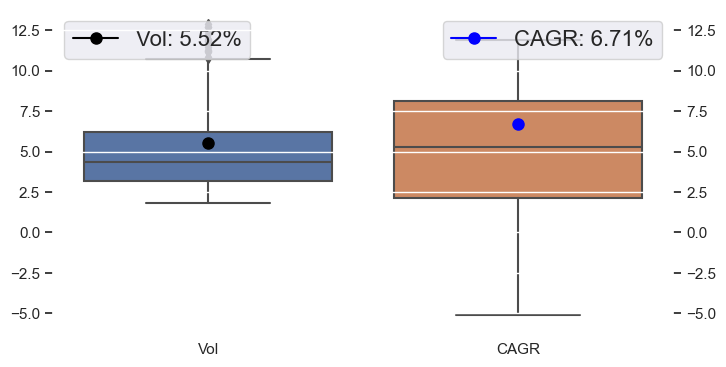

In [292]:
plot = linha_infinity[['Ret_Acum_Per', 'CAGR', 'Vol', 'Sharpe']]
plot.reset_index(inplace=True)


idx = ['Vol', 'CAGR']
df = df_clean_final[idx]
df = df[(df.Vol > df.Vol.quantile(0.1)) & (df.Vol < df.Vol.quantile(0.90))]
df = df[(df.CAGR > df.CAGR.quantile(0.1)) & (df.CAGR < df.CAGR.quantile(0.90))]



# criando uma nova figura
fig = plt.figure()

fig.subplots_adjust(top=0.9, bottom=0.1)

fig.set_size_inches(8, 4)

# adicionando um subplot à figura
ax = fig.add_subplot(1, 1, 1)
ax = sns.boxplot(data=df)
ax.set_ylabel(None)
ax.set_title(None)



ax.plot(0, plot.loc[0,'Vol'], marker='o', markersize=8, color='black', label=f"Vol: {plot.loc[0,'Vol']:.2f}%")
ax.legend()

# cria novo eixo y secundário
ax2 = ax.twinx()

# plota os dados de CAGR no novo eixo
ax2.plot(1, plot.loc[0,'CAGR'], marker='o', markersize=8, color='blue', label=f"CAGR: {plot.loc[0,'CAGR']:.2f}%")

# configura a escala do eixo y secundário
ax2.set_ylim(ax.get_ylim())
ax2.set_ylabel(None)
ax.legend(loc='upper left', fontsize = 16)
ax2.legend(loc='upper right', fontsize = 16)

# removendo os eixos
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_facecolor('None')

caminho_pasta = 'C:/Users/gahbr/OneDrive/Área de Trabalho/Nova pasta/OnePage/imagens'
nome_arquivo = '/boxplot_vol_cagr.png'
fig.savefig(caminho_pasta+nome_arquivo)


# exibindo o gráfico
plt.show()


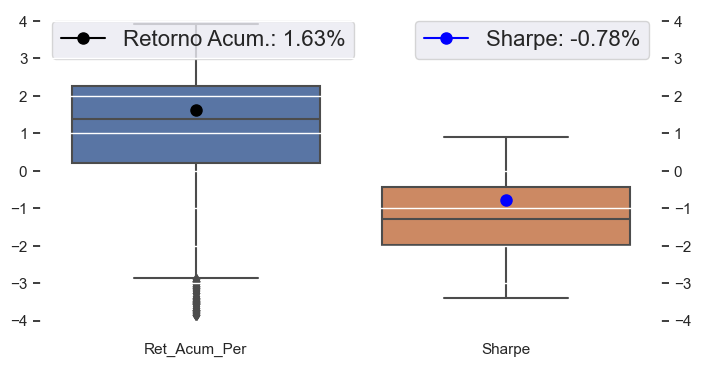

In [317]:
idx = ['Ret_Acum_Per', 'Sharpe']
df = df_clean_final[idx]


# criando uma nova figura
fig = plt.figure()

fig.subplots_adjust(top=0.9, bottom=0.1)

fig.set_size_inches(8, 4)

# adicionando um subplot à figura
ax = fig.add_subplot(1, 1, 1)
ax = sns.boxplot(data=df)
ax.set_ylabel(None)
ax.set_title(None)


ax.plot(0, plot.loc[0,'Ret_Acum_Per'], marker='o', markersize=8, color='black', label=f"Retorno Acum.: {plot.loc[0,'Ret_Acum_Per']:.2f}%")
ax.legend()

# cria novo eixo y secundário
ax2 = ax.twinx()

# plota os dados de CAGR no novo eixo
ax2.plot(1, plot.loc[0,'Sharpe'], marker='o', markersize=8, color='blue', label=f"Sharpe: {plot.loc[0,'Sharpe']:.2f}%")

# configura a escala do eixo y secundário
ax2.set_ylim(ax.get_ylim())
ax2.set_ylabel(None)
ax.legend(loc='upper left', fontsize = 16)
ax2.legend(loc='upper right', fontsize = 16)

# removendo os eixos
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_facecolor('None')

caminho_pasta = 'C:/Users/gahbr/OneDrive/Área de Trabalho/Nova pasta/OnePage/imagens'
nome_arquivo = '/boxplot_ret_sharpe.png'
fig.savefig(caminho_pasta+nome_arquivo)


# exibindo o gráfico
plt.show()



In [289]:
import os

caminho_pasta = 'C:/Users/gahbr/OneDrive/Área de Trabalho/Nova pasta/OnePage/imagens'
nome_arquivo = 'Dispersão_de_retorno .png'

if not os.path.exists(caminho_pasta):
    os.makedirs(caminho_pasta)

caminho_arquivo = os.path.join(caminho_pasta, nome_arquivo)

df_clean_final2 = df_clean_final[(df_clean_final.Vol < 20)]

fig2 = px.scatter(data_frame=df_clean_final2,
                y="Ret_Acum_Per",
                x="Vol",
                color="Sharpe", template= 'plotly_white',
                hover_name=df_clean_final2['Fundo de Investimento']
)

fig2.add_scatter(x=[vol_ano_ibov], y=[ret_ano_ibov], line_color='black', showlegend=True, name='IBOV')
fig2.add_vline(vol_ano_ibov, line_color='black')
fig2.add_hline(ret_ano_ibov, line_color='black')

vol_inf = linha_infinity.iloc[0,2]
ret_inf = linha_infinity.iloc[0,0]

fig2.add_scatter(x=[vol_inf], y=[ret_inf], line_color='blue', showlegend=True, name='Infinity')
fig2.add_vline(vol_inf, line_color='blue')
fig2.add_hline(ret_inf, line_color='blue')

fig2.update_layout(
    legend=dict(
        yanchor="bottom",
        y=0.99,
        xanchor="left",
        x=0.01
    )
)

fig2.update_xaxes(title = 'Vol')
fig2.update_layout(width=1200, height=600)
fig2.update_layout(legend_font_size=20)
fig2.update_layout(xaxis_title_font_size=30)
fig2.update_layout(yaxis_title_font_size=30)
fig2.update_layout(legend_title_text="")
fig2.write_image(caminho_arquivo)

nome_arquivo2 = 'Histograma_de_retorno .png'
caminho_arquivo = os.path.join(caminho_pasta, nome_arquivo2)
fig_1 = px.histogram(x=df_clean['Ret_Acum_Per'], nbins=100, labels = dict(x="Ret_Acum_Per", y="count"), template= 'plotly_white')
fig_1.add_vline(ibov_ret_total, line_color='red', annotation_text=f"IBOV({ibov_ret_total:.2}%)")
fig_1.add_vline(cdi_ret_total, line_color='blue', annotation_text=f"CDI({cdi_ret_total:.2}%)")
fig_1.add_vline(infinity_ret_total, line_color='black', annotation_text=f"INFINITY({infinity_ret_total:.2}%)")
fig_1.update_layout(bargap=0.01, showlegend=False)

fig_1.update_xaxes(title = 'Retorno Acumulado Perc.')
fig_1.update_layout(width=1200, height=600)
fig_1.update_layout(legend_font_size=20)
fig_1.update_layout(xaxis_title_font_size=30)
fig_1.update_layout(yaxis_title_font_size=30)
fig_1.update_layout(legend_title_text="")


fig_1.write_image(caminho_arquivo)

In [77]:
infinity_describe = []
indices = [0,1,2,4,6]
for i in indices:
    infinity_describe.append(linha_infinity.iloc[0,i])

x = df_clean.describe()
x = x[['Ret_Acum_Per', 'CAGR', 'Vol', 'Sharpe', 'Max_DD']]
x = x.rename(columns={'Ret_Acum_Per':'Ret Acum.',})
x_transposto = x.transpose()
x_transposto = x_transposto[['mean', '25%', '50%', '75%']]
x_transposto = x_transposto.rename(columns={'mean':'Media'})
x_transposto['Infinity'] = infinity_describe
x_transposto = x_transposto.applymap(lambda x: '{:.2f}'.format(x))
#x_transposto = x_transposto.astype(float)

print(x_transposto.to_html())
x_transposto.to_excel('benchmark_fundos.xlsx')

IndexError: index 0 is out of bounds for axis 0 with size 0

In [39]:
df_cdi = cdi_acumulado('2022-10-01', '2023-04-27')*100
df_cdi=df_cdi.rename(columns={'valor':'CDI'})
df_ibov = yf.download('^BVSP', start='2022-10-01', end='2023-04-27')['Adj Close']
df_ibov = (df_ibov/df_ibov.iloc[0])*100
df_ibov.index = pd.to_datetime(df_ibov.index).strftime('%Y-%m-%d')
df_cdi.index = pd.to_datetime(df_cdi.index).strftime('%Y-%m-%d')
display(df_ibov)
display(df_cdi)


[*********************100%***********************]  1 of 1 completed


Date
2022-10-03    100.000000
2022-10-04    100.082663
2022-10-05    100.916183
2022-10-06    101.228753
2022-10-07    100.207519
                 ...    
2023-04-19     89.476811
2023-04-20     89.867739
2023-04-24     89.506088
2023-04-25     88.880087
2023-04-26     88.098231
Name: Adj Close, Length: 140, dtype: float64

,CDI
data,
2022-10-03,100.000000
2022-10-04,100.101602
2022-10-05,100.152441
2022-10-06,100.203307
2022-10-07,100.254198
...,...
2023-04-19,107.203842
2023-04-20,107.258288
2023-04-24,107.312763


In [40]:
informes = busca_informes_diarios_cvm_por_periodo(data_inicio='2022-10-01', data_fim='2023-04-27')
df_infinity = consulta_fundo(informes, cpnj_axiom_infinity)['cotas_normalizadas']
#df_infinity = df_infinity.rename(columns={None:'Infinity'})
df_infinity


DT_COMPTC
2022-10-03    100.000000
2022-10-04    100.060988
2022-10-05    100.109244
2022-10-06    100.152723
2022-10-07    100.182735
                 ...    
2023-04-18    103.961029
2023-04-19    103.453077
2023-04-20    103.680558
2023-04-24    103.528771
2023-04-25    103.442559
Name: cotas_normalizadas, Length: 140, dtype: float64

In [318]:
dd = pd.concat([df_cdi, df_ibov, df_infinity], axis=1)
dd = dd.rename(columns={'cotas_normalizadas':'Infinity', 
                        'Adj Close': 'Ibovespa'})
dd

,CDI,Ibovespa,Infinity
2022-10-03,100.000000,100.000000,100.000000
2022-10-04,100.101602,100.082663,100.060988
2022-10-05,100.152441,100.916183,100.109244
2022-10-06,100.203307,101.228753,100.152723
2022-10-07,100.254198,100.207519,100.182735
...,...,...,...
2023-04-19,107.203842,89.476811,103.453077
2023-04-20,107.258288,89.867739,103.680558
2023-04-24,107.312763,89.506088,103.528771
2023-04-25,107.367265,88.880087,103.442559


In [319]:
fig = px.line(data_frame=dd, template='plotly_white')
fig.update_xaxes(title = None)
fig.show()

In [320]:
import os

caminho_pasta = 'C:/Users/gahbr/OneDrive/Área de Trabalho/Nova pasta/OnePage/imagens'
nome_arquivo = 'infinity_cdi_ibov.png'

if not os.path.exists(caminho_pasta):
    os.makedirs(caminho_pasta)

caminho_arquivo = os.path.join(caminho_pasta, nome_arquivo)

fig = px.line(data_frame=dd, template='plotly_white')
fig.update_layout(width=1200, height=600)
fig.update_layout(legend_font_size=20)
fig.update_layout(xaxis_title_font_size=30)
fig.update_layout(yaxis_title_font_size=30)
fig.update_xaxes(title = None)
fig.update_layout(legend_title_text="")
fig.write_image(caminho_arquivo)

In [37]:
codigo_bcb = 12
url = 'http://api.bcb.gov.br/dados/serie/bcdata.sgs.{}/dados?formato=json'.format(codigo_bcb)

cdi = pd.read_json(url)
cdi['data'] = pd.to_datetime(cdi['data'], dayfirst=True)
cdi.set_index('data', inplace=True)
cdi_ts = cdi[data_inicio : data_fim]/100
cdi_acum = (1 + cdi_ts).cumprod()
cdi_ret_total = (cdi_acum.iloc[-1][0]-1)*100


ibov = yf.download('^BVSP', start=data_inicio, end=data_fim)['Adj Close']
ibov = (ibov / ibov.iloc[0])*100
ibov_ret = ibov.pct_change()
ret_ano_ibov = cagr(ibov_ret, rf=0, nperiods=0) * 100
vol_ano_ibov = qs.stats.volatility(ibov_ret, prepare_returns=False) * 100
ibov_ret_total = (ibov[-1]/100 -1)*100

cdi_ts = (1 + cdi_ts).cumprod()
cdi_ts.reset_index(inplace=True)
cdi_ts = cdi_ts.rename(columns={'data': 'Date', 'valor': 'CDI'})
cdi_ts['Date'] = pd.to_datetime(cdi_ts['Date'])
cdi_ts.set_index(['Date'], inplace=True)

ibov = pd.DataFrame(ibov)
ibov.reset_index(inplace=True)
ibov = ibov.rename(columns={'Date': 'Date', 'Adj Close': 'IBOV'})
ibov['Date'] = pd.to_datetime(ibov['Date'])
ibov.set_index(['Date'], inplace=True)
ibov.index = ibov.index.strftime('%Y-%m-%d')
ibov.index = pd.to_datetime(ibov.index)

[*********************100%***********************]  1 of 1 completed


In [53]:
cdi_ret_total

3.3029831930710296

In [38]:
year=2023
month_start=1
month_end=3
data_inicio, data_fim = set_date(year, month_start, month_end)

fundos_rk = df_metrics(data_inicio, data_fim, classe='Fundo Multimercado')

fundos_rk = fundos_rk[fundos_rk.PL > 0]
df_clean = fundos_rk[(fundos_rk.CAGR > fundos_rk.CAGR.quantile(0.05)) & (fundos_rk.CAGR < fundos_rk.CAGR.quantile(0.95))]
infinity_ret_total = df_clean[df_clean.index == cpnj_axiom_infinity].Ret_Acum_Per[0]

In [55]:
df_prices = pd.merge(pd.merge(cdi_ts,pd.DataFrame(ibov),on='Date'), df_index, on='Date')
df_prices

NameError: name 'df_index' is not defined

In [40]:
from pandas.tseries.offsets import BDay

today = pd.to_datetime("now")
end = date.today() - datetime.timedelta(days= 1)

today_last_year = today - pd.Timedelta(365, "day")

df_filter = df_prices[today_last_year: today]
cotas_norm = df_filter / df_filter.iloc[0]
ret = cotas_norm.pct_change()
ret.index = pd.to_datetime(ret.index)


if end.month == 1:
    one_month_ago = date(end.year-1, end.month+11, end.day).strftime('%Y-%m-%d')
else:
    one_month_ago = date(end.year, end.month-1, end.day).strftime('%Y-%m-%d')
df_month = df_filter[df_filter.index > one_month_ago]
ret_month = (df_month / df_month.iloc[0]).pct_change()

#one_year_ago = date(end.year-1, end.month, end.day).strftime('%Y-%m-%d')
#df_year = df_filter[df_filter.index > one_year_ago]
#ret_m = (df_month / df_month.iloc[0]).pct_change()

YTD = date(end.year, 1, 1).strftime('%Y-%m-%d')
df_ytd = df_filter[df_filter.index > YTD]
ret_ytd = (df_ytd / df_ytd.iloc[0]).pct_change()


df_filter.index = pd.to_datetime(df_filter.index).strftime("%Y-%m-%d")

cagr_ = cagr(ret, rf=0, nperiods=0)
vol = qs.stats.volatility(ret, prepare_returns=False)
excess_ret = cagr(ret, rf=0.1150, nperiods=252)
es = cvar(ret, confidence=0.95, prepare_returns=False)

res_12m = pd.DataFrame()
res_12m['Ret_Mes'] = (((df_month / df_month.iloc[0]).iloc[-1]) - 1) * 100
res_12m['Ret_YTD'] = (((df_ytd / df_ytd.iloc[0]).iloc[-1]) - 1) * 100
res_12m['Ret_Acum_Per'] = ((cotas_norm.iloc[-1]) - 1) * 100
res_12m['Ret_Ano'] = cagr_.values * 100
res_12m['Vol'] = vol.values * 100
res_12m['Excess_Ret'] = excess_ret.values * 100
res_12m['Sharpe'] = (excess_ret.values/vol.values) * 100
res_12m['ES_95'] = es.values * 100

C:\Users\gahbr\AppData\Local\Temp\ipykernel_5548\2543294956.py:3: FutureWarning:

The parsing of 'now' in pd.to_datetime without `utc=True` is deprecated. In a future version, this will match Timestamp('now') and Timestamp.now()



NameError: name 'df_prices' is not defined

  <!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Strict//EN" "http://www.w3.org/TR/xhtml1/DTD/xhtml1-strict.dtd">
0                                                                   <html xmlns="http://www.w3.org/1999/xhtml">
1                                                                                                        <head>
2                                                                   <title>500 - Internal server error.</title>
3                                                                                       <style type="text/css">
4                                                                                                          <!--


IndexError: list index out of range

Tabela não encontrada no HTML


In [ ]:
import datetime 
import investpy as inv

In [ ]:
bondsBR = inv.get_bonds_list('brazil')
bondsBR

['Brazil 3M',
 'Brazil 6M',
 'Brazil 9M',
 'Brazil 1Y',
 'Brazil 2Y',
 'Brazil 3Y',
 'Brazil 5Y',
 'Brazil 8Y',
 'Brazil 10Y']

In [ ]:
bonds_overview = inv.get_bonds_overview('brazil')
bonds_overview

ConnectionError: ERR#0015: error 403, try again later.

In [296]:
import requests

base_url = 'https://stooq.com/q/l/'

query = 'spx.us'
url = base_url + query

response = requests.get(url)

if response.status_code == 200:
    # O pedido foi bem-sucedido
    data = response.text
else:
    # O pedido falhou
    data = None


In [295]:
from urllib.request import urlretrieve
import pandas as pd

ticker =  '^SPX'

interval='d'
url = f'https://stooq.com/q/d/l/?s={ticker}&i={interval}'
csv_file=ticker+'.csv'

urlretrieve(url, csv_file)

('^SPX.csv', <http.client.HTTPMessage at 0x2e7a37f6290>)

In [297]:
#ler arquivo direto em dataframe
import pandas as pd

cod = '^SPX'
interval = 'd'
url = f'https://stooq.com/q/d/l/?s={cod}&i={interval}'

df_teste = pd.read_csv(url, index_col=0, parse_dates=True)
df_teste

,Open,High,Low,Close,Volume
Date,,,,,
1789-05-01,0.51,0.51,0.51,0.51,NaN
1789-06-01,0.51,0.51,0.51,0.51,NaN
1789-07-01,0.50,0.50,0.50,0.50,NaN
1789-08-01,0.50,0.51,0.50,0.51,NaN
1789-09-01,0.51,0.51,0.50,0.51,NaN
...,...,...,...,...,...
2023-04-21,4132.14,4138.02,4113.86,4133.52,2.298538e+09
2023-04-24,4132.07,4142.41,4117.77,4137.04,2.122318e+09
2023-04-25,4126.43,4126.43,4071.38,4071.63,2.574201e+09


In [298]:
df = pd.read_csv(csv_file).tail()
df

,Date,Open,High,Low,Close,Volume
38928,2023-04-21,4132.14,4138.02,4113.86,4133.52,2.298538e+09
38929,2023-04-24,4132.07,4142.41,4117.77,4137.04,2.122318e+09
38930,2023-04-25,4126.43,4126.43,4071.38,4071.63,2.574201e+09
38931,2023-04-26,4087.78,4089.67,4049.35,4055.99,2.702715e+09
38932,2023-04-27,4075.29,4138.21,4075.29,4135.35,2.103790e+09


In [299]:
def busca(ticker):
    interval='d'
    url = f'https://stooq.com/q/d/l/?s={ticker}&i={interval}'
    csv_file=ticker+'.csv'
    urlretrieve(url, csv_file)
    return csv_file

In [300]:
#SP500
planilha_1 = busca("^SPX")
#print(planilha)
df1 = pd.read_csv(planilha_1)
df1 = df1.set_index('Date')
df1

,Open,High,Low,Close,Volume
Date,,,,,
1789-05-01,0.51,0.51,0.51,0.51,NaN
1789-06-01,0.51,0.51,0.51,0.51,NaN
1789-07-01,0.50,0.50,0.50,0.50,NaN
1789-08-01,0.50,0.51,0.50,0.51,NaN
1789-09-01,0.51,0.51,0.50,0.51,NaN
...,...,...,...,...,...
2023-04-21,4132.14,4138.02,4113.86,4133.52,2.298538e+09
2023-04-24,4132.07,4142.41,4117.77,4137.04,2.122318e+09
2023-04-25,4126.43,4126.43,4071.38,4071.63,2.574201e+09


In [301]:
#S&P 500 VIX Cash
planilha_2 = busca("VI.C")
#print(planilha)
df2 = pd.read_csv(planilha_2)
df2 = df2.set_index('Date')
df2

,Open,High,Low,Close
Date,,,,
1990-01-02,17.24,17.24,17.24,17.24
1990-01-03,18.19,18.19,18.19,18.19
1990-01-04,19.22,19.22,19.22,19.22
1990-01-05,20.11,20.11,20.11,20.11
1990-01-08,20.26,20.26,20.26,20.26
...,...,...,...,...
2023-04-20,16.85,17.69,16.33,17.17
2023-04-21,17.51,17.71,16.58,16.77
2023-04-24,18.22,18.24,16.74,16.89


In [302]:
#Nasdaq Composite
planilha_3 = busca("^NDQ")
#print(planilha)
df3 = pd.read_csv(planilha_3)
df3 = df3.set_index('Date')
df3

,Open,High,Low,Close,Volume
Date,,,,,
1938-01-03,5.6500,5.750,5.590,5.630,NaN
1938-01-04,5.7500,5.910,5.750,5.880,NaN
1938-01-05,5.8400,5.970,5.830,5.850,NaN
1938-01-06,5.9400,6.120,5.940,6.110,NaN
1938-01-07,6.1000,6.120,6.020,6.060,NaN
...,...,...,...,...,...
2023-04-21,12046.0300,12097.150,11986.820,12072.460,4.206492e+09
2023-04-24,12053.4700,12103.580,11960.300,12037.200,4.380200e+09
2023-04-25,11968.8100,11990.460,11798.770,11799.160,NaN


In [303]:
# Bovespa Index - Brazil (^BVP)
planilha_4 = busca("^BVP")
#print(planilha)
df4 = pd.read_csv(planilha_4)
df4 = df4.set_index('Date')
df4

,Open,High,Low,Close,Volume
Date,,,,,
1989-07-12,0.001,0.001,0.001,0.001,NaN
1989-07-14,0.001,0.001,0.001,0.001,NaN
1989-07-25,0.001,0.001,0.001,0.001,NaN
1989-08-01,0.001,0.001,0.001,0.001,NaN
1989-08-04,0.001,0.001,0.001,0.001,NaN
...,...,...,...,...,...
2023-04-20,103913.500,104615.200,103087.000,104366.820,1.237798e+09
2023-04-24,104366.820,104821.970,103247.040,103946.580,1.093541e+09
2023-04-25,103946.580,103946.580,102633.100,103220.090,1.087321e+09


In [304]:
#Hang Seng Index - Hong Kong (^HSI)
planilha_5 = busca("^HSI")
#print(planilha)
df5 = pd.read_csv(planilha_5)
df5 = df5.set_index('Date')
df5

,Open,High,Low,Close,Volume
Date,,,,,
1969-11-24,158.50,158.50,158.50,158.50,NaN
1969-11-25,156.78,156.78,156.78,156.78,NaN
1969-11-26,155.35,155.35,155.35,155.35,NaN
1969-11-27,155.51,155.51,155.51,155.51,NaN
1969-11-28,157.01,157.01,157.01,157.01,NaN
...,...,...,...,...,...
2023-04-21,20330.15,20376.64,19975.70,20075.73,2.494224e+09
2023-04-24,20049.87,20145.02,19735.51,19959.94,2.247902e+09
2023-04-25,19903.53,19910.01,19530.13,19617.88,2.196274e+09


In [307]:
# CRB Commodity Index (^CRY)
planilha_6 = busca("^CRY")
#print(planilha)
df6 = pd.read_csv(planilha_6)
df6 = df6.set_index('Date')
df6

,Open,High,Low,Close
Date,,,,
1994-01-03,113.9400,113.9400,113.9400,113.9400
1994-01-04,114.1700,114.1700,114.1700,114.1700
1994-01-05,116.2700,116.2700,116.2700,116.2700
1994-01-06,116.5100,116.5100,116.5100,116.5100
1994-01-07,116.3000,116.3000,116.3000,116.3000
...,...,...,...,...
2023-04-21,271.9082,271.9082,270.7983,270.7983
2023-04-24,270.7983,272.6052,270.7983,272.6052
2023-04-25,272.6052,272.6052,268.7822,268.7822


In [310]:
# U.S. Dollar / Brazilian Real (USDBRL)
planilha_7 = busca("usdbrl")
#print(planilha)
df7 = pd.read_csv(planilha_7)
df7 = df7.set_index('Date')
df7

,Open,High,Low,Close
Date,,,,
1995-01-02,0.8440,0.8440,0.8440,0.8440
1995-01-03,0.8450,0.8450,0.8450,0.8450
1995-01-04,0.8450,0.8450,0.8450,0.8450
1995-01-05,0.8430,0.8430,0.8430,0.8430
1995-01-06,0.8400,0.8400,0.8400,0.8400
...,...,...,...,...
2023-04-21,5.0494,5.0494,5.0494,5.0494
2023-04-24,5.0680,5.0839,5.0468,5.0470
2023-04-25,5.0645,5.0810,5.0303,5.0700


In [336]:
dfs = [df1, df2, df3, df4, df5, df6, df7]

merged = dfs[0]
for df in dfs[1:]:
    merged = pd.merge(merged, df, on='Date', how='inner')
merged
datas = merged.index.tolist()
#datas

C:\Users\gahbr\AppData\Local\Temp\ipykernel_3888\2580418434.py:5: FutureWarning:

Passing 'suffixes' which cause duplicate columns {'Close_x', 'High_x', 'Open_x', 'Low_x'} in the result is deprecated and will raise a MergeError in a future version.

C:\Users\gahbr\AppData\Local\Temp\ipykernel_3888\2580418434.py:5: FutureWarning:

Passing 'suffixes' which cause duplicate columns {'Volume_x'} in the result is deprecated and will raise a MergeError in a future version.

C:\Users\gahbr\AppData\Local\Temp\ipykernel_3888\2580418434.py:5: FutureWarning:

Passing 'suffixes' which cause duplicate columns {'Close_x', 'High_x', 'Open_x', 'Low_x'} in the result is deprecated and will raise a MergeError in a future version.



In [338]:
# Data de hoje
hoje = date.today()

# Data de um dia atrás
data_d1 = datas[-1]

# Data de dois dias atrás
data_d2 = datas[-2]

# Data de uma semana atrás
data_w1 = datas[-7]

# Data de um mês atrás
data_m1 = datas[-30]
print(data_d1,data_d2,data_w1,data_m1)


df_selected = pd.DataFrame()
df_selected['S&P500'] = df1['Close'].loc[[data_d1, data_d2, data_w1, data_m1]]
df_selected['VIX'] = df2['Close'].loc[[data_d1, data_d2, data_w1, data_m1]]
df_selected['Nasdaq'] = df3['Close'].loc[[data_d1, data_d2, data_w1, data_m1]]
df_selected['Bovespa'] = df4['Close'].loc[[data_d1, data_d2, data_w1, data_m1]]
df_selected['Hang Seng'] = df5['Close'].loc[[data_d1, data_d2, data_w1, data_m1]]
df_selected['CRB'] = df6['Close'].loc[[data_d1, data_d2, data_w1, data_m1]]
df_selected['Dolar'] = df7['Close'].loc[[data_d1, data_d2, data_w1, data_m1]]
df_selected


2023-04-26 2023-04-25 2023-04-17 2023-03-10


,S&P500,VIX,Nasdaq,Bovespa,Hang Seng,CRB,Dolar
Date,,,,,,,
2023-04-26,4055.99,18.84,11854.35,102312.10,19757.27,264.9431,5.0406
2023-04-25,4071.63,18.76,11799.16,103220.09,19617.88,268.7822,5.0700
2023-04-17,4151.32,16.95,12157.72,106015.67,20782.45,276.8093,4.9456
2023-03-10,3861.59,24.80,11138.89,103618.20,19319.92,264.9929,5.1938


In [350]:
df_transposed = df_selected.transpose()
df_transposed = df_transposed.rename(columns = {f'{data_d1}':'d-1',
                                                f'{data_d2}':'d-2',
                                                f'{data_w1}':'w-1',
                                                f'{data_m1}':'m-1'})
df_transposed

Date,d-1,d-2,w-1,m-1
S&P500,4055.9900,4071.6300,4151.3200,3861.5900
VIX,18.8400,18.7600,16.9500,24.8000
Nasdaq,11854.3500,11799.1600,12157.7200,11138.8900
Bovespa,102312.1000,103220.0900,106015.6700,103618.2000
Hang Seng,19757.2700,19617.8800,20782.4500,19319.9200
CRB,264.9431,268.7822,276.8093,264.9929
Dolar,5.0406,5.0700,4.9456,5.1938


In [351]:
#variacao diaria e semanal

diaria = []
semanal = []
mensal = []
for i in range(len(df_transposed)):
    diaria.append(((df_transposed.iloc[i, 1]-df_transposed.iloc[i,0])/df_transposed.iloc[i,1]).round(4)*100)
    semanal.append(((df_transposed.iloc[i, 2]-df_transposed.iloc[i,0])/df_transposed.iloc[i,2]).round(4)*100)
    mensal.append(((df_transposed.iloc[i, 3]-df_transposed.iloc[i,0])/df_transposed.iloc[i,3]).round(4)*100)

df_transposed['% Diaria'] = diaria
df_transposed['% Semanal'] = semanal
df_transposed['% Mensal'] = mensal

df_transposed = df_transposed[['d-1','w-1', 'm-1', '% Diaria', '% Semanal', '% Mensal']]
df_transposed 

Date,d-1,w-1,m-1,% Diaria,% Semanal,% Mensal
S&P500,4055.9900,4151.3200,3861.5900,0.38,2.30,-5.03
VIX,18.8400,16.9500,24.8000,-0.43,-11.15,24.03
Nasdaq,11854.3500,12157.7200,11138.8900,-0.47,2.50,-6.42
Bovespa,102312.1000,106015.6700,103618.2000,0.88,3.49,1.26
Hang Seng,19757.2700,20782.4500,19319.9200,-0.71,4.93,-2.26
CRB,264.9431,276.8093,264.9929,1.43,4.29,0.02
Dolar,5.0406,4.9456,5.1938,0.58,-1.92,2.95


In [352]:
result = df_transposed.to_html()
df_transposed.to_excel('cotacoes.xlsx')

In [ ]:
print(result)

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>Date</th>
      <th>d-1</th>
      <th>d-2</th>
      <th>w-1</th>
      <th>% diaria</th>
      <th>% semanal</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>S&amp;P500</th>
      <td>4151.3200</td>
      <td>4137.6400</td>
      <td>4105.0200</td>
      <td>-0.33</td>
      <td>-1.13</td>
    </tr>
    <tr>
      <th>VIX</th>
      <td>16.9500</td>
      <td>17.0700</td>
      <td>18.4000</td>
      <td>0.70</td>
      <td>7.88</td>
    </tr>
    <tr>
      <th>Nasdaq</th>
      <td>12157.7200</td>
      <td>12123.4700</td>
      <td>12087.9600</td>
      <td>-0.28</td>
      <td>-0.58</td>
    </tr>
    <tr>
      <th>Bovespa</th>
      <td>106015.6700</td>
      <td>106279.3700</td>
      <td>100821.7300</td>
      <td>0.25</td>
      <td>-5.15</td>
    </tr>
    <tr>
      <th>Hang Seng</th>
      <td>20782.4500</td>
      <td>20438.8100</td>
      <td>20331.2000</td>
      <td>-1.6

In [41]:
#posição do time

pos_time = {'Caixa':'Comprado', 
            'RF Pós': 'Vendido',
            'Inflação Nom.': 'Comprado',
            'RVBR': 'Comprado',
            'RVInt': 'Comprado',
            'Commodity': 'Vendido',
            'Moedas': 'Neutro',
            'MM': 'Comprado',
            'RE': 'Comprado',
            'Alt': 'Vendido'}

df_pos_time = pd.DataFrame(pos_time.items(), columns=['Ativo', 'Posição']).set_index('Ativo')
df_pos_time

,Posição
Ativo,
Caixa,Comprado
RF Pós,Vendido
Inflação Nom.,Comprado
RVBR,Comprado
RVInt,Comprado
Commodity,Vendido
Moedas,Neutro
MM,Comprado
RE,Comprado


In [42]:
result = df_pos_time.to_html()
df_pos_time.to_excel('pos_time.xlsx', startrow=1)
print(result)

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Posição</th>
    </tr>
    <tr>
      <th>Ativo</th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>Caixa</th>
      <td>Comprado</td>
    </tr>
    <tr>
      <th>RF Pós</th>
      <td>Vendido</td>
    </tr>
    <tr>
      <th>Inflação Nom.</th>
      <td>Comprado</td>
    </tr>
    <tr>
      <th>RVBR</th>
      <td>Comprado</td>
    </tr>
    <tr>
      <th>RVInt</th>
      <td>Comprado</td>
    </tr>
    <tr>
      <th>Commodity</th>
      <td>Vendido</td>
    </tr>
    <tr>
      <th>Moedas</th>
      <td>Neutro</td>
    </tr>
    <tr>
      <th>MM</th>
      <td>Comprado</td>
    </tr>
    <tr>
      <th>RE</th>
      <td>Comprado</td>
    </tr>
    <tr>
      <th>Alt</th>
      <td>Vendido</td>
    </tr>
  </tbody>
</table>


In [104]:
# Indice Anbima
df = pd.read_excel('anbima_index.xlsx')
anb_index = df.iloc[:, 1:12].drop(['Date.2', 'Date.3', 'Date.4', 'Date.5'], axis=1)
anb_index.rename(columns={'Date.1': 'Date'}, inplace=True)
anb_index = anb_index.set_index('Date')
anb_index = anb_index.loc['2023-01-01':]
anb_index = anb_index.sort_index()
returns = anb_index.pct_change()
acumulado_2023 = ((1 + returns).cumprod()-1)*100
acumulado_2023_final = acumulado_2023.tail(1).dropna
#acumulado_2023 = acumulado_2023.reset_index().dropna()
#acumulado_2023 = acumulado_2023.iloc[:,1:6]
acumulado_2023


C:\Users\gahbr\AppData\Local\Temp\ipykernel_5548\965865781.py:6: FutureWarning:

Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.



,IHFA,IMAB,IMAB5,IRFM,IRFM1+,IRFM1
Date,,,,,,
2023-01-02,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-03,-0.056968,-0.559770,-0.122317,-0.330004,-0.510783,-0.035463
2023-01-04,-0.080541,-0.803796,-0.207153,-0.521454,-0.815493,-0.042236
2023-01-05,0.111098,-0.522950,-0.033135,-0.133475,-0.244460,0.047313
2023-01-06,0.142965,-0.122597,0.140056,0.251444,0.316841,0.144828
...,...,...,...,...,...,...
2023-03-27,0.882456,4.628189,4.745011,3.998004,4.488155,3.141725
2023-03-28,0.875690,4.497690,4.594545,3.956589,4.415082,3.155198
2023-03-29,1.027168,4.447295,4.610304,3.814694,4.178788,3.176711


In [127]:

ultima_linha = acumulado_2023.iloc[-1, :]
linha_infinity



,Ret_Acum_Per,CAGR,Vol,Excess_Return,Sharpe,ES_95,Max_DD,Fundo de Investimento,Classe,PL
Infinity,,,,,,,,,,
46.649.069/0001-41,1.631374,6.705896,5.516344,-4.330151,-0.784968,-0.545298,-1.718835,AXIOM INFINITY FUNDO DE INVESTIMENTO MULTIMERCADO CRÉDITO PRIVADO,Fundo Multimercado,38258171.01


C:\Users\gahbr\AppData\Local\Temp\ipykernel_5548\12162703.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



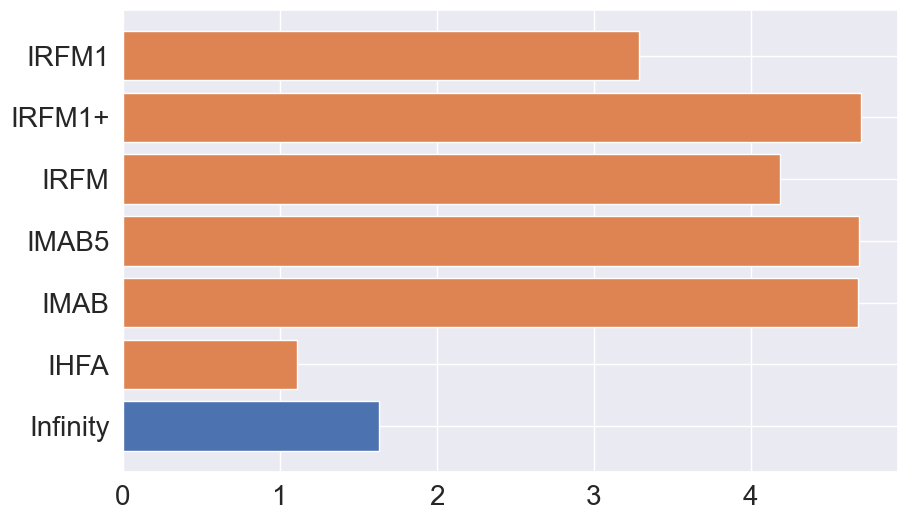

In [147]:
#teste
ultima_linha = acumulado_2023.iloc[-1, :]
linha_infinity['nome'] = 'Infinity'

# criando um gráfico de barras com a última coluna
plt.barh(linha_infinity['nome'], linha_infinity['Ret_Acum_Per'])
plt.barh(ultima_linha.index, ultima_linha)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

# exibindo o gráfico
plt.show()

C:\Users\gahbr\AppData\Local\Temp\ipykernel_5548\520916967.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



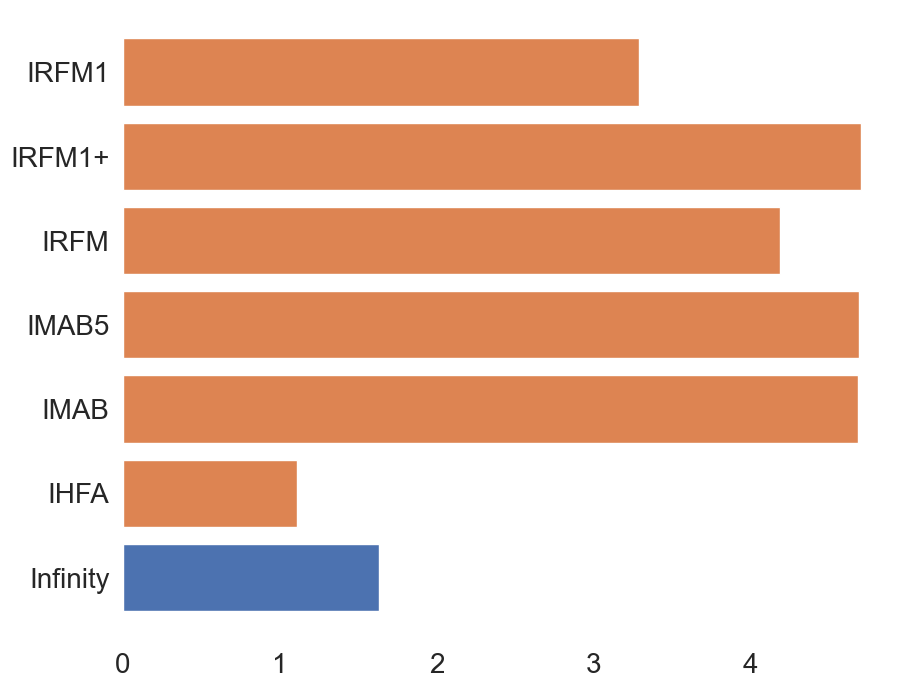

In [193]:
import matplotlib.pyplot as plt

ultima_linha = acumulado_2023.iloc[-1, :]
linha_infinity['nome'] = 'Infinity'

# criando uma nova figura
fig = plt.figure()

fig.subplots_adjust(top=0.95, bottom=0.05)

fig.set_size_inches(10, 7)

# adicionando um subplot à figura
ax = fig.add_subplot(1, 1, 1)

# criando um gráfico de barras com a última coluna
ax.barh(linha_infinity['nome'], linha_infinity['Ret_Acum_Per'])
ax.barh(ultima_linha.index, ultima_linha)

# ajustando as fontes dos eixos
ax.tick_params(axis='both', which='major', labelsize=20)

# removendo os eixos
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_facecolor('None')

caminho_pasta = 'C:/Users/gahbr/OneDrive/Área de Trabalho/Nova pasta/OnePage/imagens'
nome_arquivo = '/ima.png'

fig.savefig(caminho_pasta+nome_arquivo)


# exibindo o gráfico
plt.show()

In [173]:
ultima_linha = acumulado_2023.iloc[-1, :]
inf = pd.DataFrame()
inf['ret'] = linha_infinity['Ret_Acum_Per']
inf['ret'] = float(round(inf['ret'], 2))
inf = inf.reset_index()
inf['nome'] = 'Infinity'
display(inf)

# criando um gráfico de barras com a última coluna
fig = px.bar(x=ultima_linha.values, y=ultima_linha.index, orientation='h')

# adicionando uma nova barra
fig.add_bar(x=[inf['ret']], y=[inf['nome']])

# exibindo o gráfico
fig.show()


,Infinity,ret,nome
0,46.649.069/0001-41,1.63,Infinity


In [5]:
import pdfcrowd
import sys

try:
    # create the API client instance
    client = pdfcrowd.HtmlToPdfClient('demo', 'ce544b6ea52a5621fb9d55f8b542d14d')

    # run the conversion and write the result to a file
    client.convertFileToFile("C:/Users/gahbr/OneDrive/Área de Trabalho/Nova pasta/OnePage/index.html", 'MyLayout.pdf')
except pdfcrowd.Error as why:
    # report the error
    sys.stderr.write('Pdfcrowd Error: {}\n'.format(why))

    # rethrow or handle the exception
    raise

TypeError: HtmlToPdfClient.convertFileToFile() got an unexpected keyword argument 'ignore_images'

In [2]:
!pip install pdfcrowd

     ---------------------------------------- 0.0/54.8 kB ? eta -:--:--
     ---------------------------------------- 54.8/54.8 kB 3.0 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.0 -> 23.1.2
[notice] To update, run: C:\Users\gahbr\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip
